In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.notebook import tqdm
from collections import defaultdict
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

red = '#FF3300'
blue = '#0066CC'
green = '#00CC33'

warnings.filterwarnings("ignore")
sns.set(style='whitegrid', font_scale=1.4, palette='Set2')

**Простая задачка на таблицу сопряженности:**

Выдается сводная статистика о посетителях сайта miptstats.github.io за период с февраля по май этого года. В каждой ячейке таблицы записано количество посетителей определенного условия, которые хотя бы раз посетили сайт. Пол посетителя определяется технологией Яндекс.Метрики.

In [ ]:
data = pd.DataFrame(
    {'Мужской': [7160, 3286, 224, 143, 1022, 826],
     'Женский': [3318, 1593, 69, 87, 328, 508]},
    index=['Chrome', 'Яндекс Браузер', 'Firefox',
           'Safari', 'Opera', 'Edge']
)
data

,Мужской,Женский
Chrome,7160,3318
Яндекс Браузер,3286,1593
Firefox,224,69
Safari,143,87
Opera,1022,328
Edge,826,508


Проверим гипотезу о том, что тип используемого браузера не зависит от пола посетителя. Сделайте вывод.

In [ ]:
sps.chi2_contingency(data)

(74.07678148306084,
 1.449572304539852e-14,
 5,
 array([[7146.19467787, 3331.80532213],
        [3327.57051282, 1551.42948718],
        [ 199.8315557 ,   93.1684443 ],
        [ 156.86436113,   73.13563887],
        [ 920.72559793,  429.27440207],
        [ 909.81329455,  424.18670545]]))

Из напечатанной таблицы видим, что у нас нет клеток, где ожидаемое число значений меньше 5, поэтому критерий применим. Значение p-value меньше 0.05, поэтому гипотеза о независимости пола и браузера отвергается.

---
---
---
---
---
---
---

Скачаем <a href="http://archive.ics.uci.edu/ml/datasets/Bank+Marketing">данные</a> маркетинговых кампаний португальского банковского учреждения. Цель задачи &mdash; с целью дальнейшего исследования понять, какие условия (среди 20 признаков) влияют на подписание клиентом срочного депозита (величина $y$). Выполним задачу двумя способами:

* методами анализа зависимостей, выяснив, какие характеристики клиента оказывают влияние на целевую переменную, и указав степень влияния;

* вычислив важность признаков, полученной с помощью Random Forest, разбив предварительно данные на обучающую и тестовую части.

In [ ]:
data = pd.read_csv('./bank-additional.csv', sep=';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


Выделим отдельно целевую переменную

In [ ]:
y = data['y']
data.drop(columns='y', inplace=True)

Разделим данные на обучающую и тестовую части.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=1)

**1. Критерий хи-квадрат для таблиц сопряженности.**

В данных есть и непрерывные, и категориальные признаки. При этом отклик является категориальным. Поэтому будем применять критерий хи-квадрат, предварительно бинаризовав вещественные признаки.

*1.1 Категориальные признаки*

Сначала разберемся с категориальными признаками. Проверим условие применимости критерия для всех признаков.

In [ ]:
def check_applicability(features, y):
    '''
    Для каждого категориального признака проверяет условие применимости критерия хи-квадрат
    при проверке гипотезы о его независимости с целевой переменной.

    features -- значения категориальных признаков
    y -- целевая переменная
    '''

    result = defaultdict(list)

    for feature in features:
        _, _, _, expected = sps.chi2_contingency(pd.crosstab(X_train[feature], y))
        result['Признак'].append(feature)
        mean = (expected < 5).mean()
        result['Кол-во ячеек с ожидаемым < 5'].append(mean)
        result['Критерий применим'].append(mean < 0.2)

    display(pd.DataFrame(result))

Проверим условия применимости для всех категориальных признаков

In [ ]:
categorical_features = X_train.columns[X_train.dtypes == object]

check_applicability(categorical_features, y_train)

,Признак,Кол-во ячеек с ожидаемым < 5,Критерий применим
0,job,0.041667,True
1,marital,0.125000,True
2,education,0.125000,True
3,default,0.333333,False
4,housing,0.000000,True
5,loan,0.000000,True
6,contact,0.000000,True
7,month,0.100000,True
8,day_of_week,0.000000,True
9,poutcome,0.000000,True


Как видим, критерий применим ко всем признакам, кроме `default`.

Посмотрим, какие значения принимает этот признак. Всего одно значение `yes`!`

In [ ]:
np.unique(X_train['default'], return_counts=True)

(array(['no', 'unknown', 'yes'], dtype=object), array([2479,  609,    1]))

Заглянем в тест, а тут `yes` вообще нет

In [ ]:
np.unique(X_test['default'], return_counts=True)

(array(['no', 'unknown'], dtype=object), array([836, 194]))

Кажется, пользы от одного `yes` вообще никакой нет. Заменим его на `unknown`.

In [ ]:
X_train.loc[X_train['default'] == 'yes', 'default'] = 'unknown'
X_test.loc[X_test['default'] == 'yes', 'default'] = 'unknown'

И проверим снова

In [ ]:
check_applicability(categorical_features, y_train)

,Признак,Кол-во ячеек с ожидаемым < 5,Критерий применим
0,job,0.041667,True
1,marital,0.125000,True
2,education,0.125000,True
3,default,0.000000,True
4,housing,0.000000,True
5,loan,0.000000,True
6,contact,0.000000,True
7,month,0.100000,True
8,day_of_week,0.000000,True
9,poutcome,0.000000,True


*1.2 Вещественные признаки*


Теперь разберемся с вещественными признаками. Разобьем на группы по квантилями.

In [ ]:
n_bins = 5  # количество бинов разбиения вещественного признака

# вещественные признаки
real_features = X_train.columns[X_train.dtypes != object]

for feature in real_features:
    # рразбиваем признак
    quantiles = np.quantile(X_train[feature], np.linspace(0, 1, n_bins + 1))
    # добавляем его в данные
    X_train.insert(
        len(X_train.columns), f'{feature}_binarized',
        pd.cut(X_train[feature], quantiles, duplicates='drop'),
    )

Проверим применимость критерия хи-квадрат

In [ ]:
all_features = categorical_features.union(real_features + '_binarized')

check_applicability(all_features, y_train)

,Признак,Кол-во ячеек с ожидаемым < 5,Критерий применим
0,age_binarized,0.000000,True
1,campaign_binarized,0.000000,True
2,cons.conf.idx_binarized,0.000000,True
3,cons.price.idx_binarized,0.000000,True
4,contact,0.000000,True
5,day_of_week,0.000000,True
6,default,0.000000,True
7,duration_binarized,0.000000,True
8,education,0.125000,True
9,emp.var.rate_binarized,0.000000,True


Как видим, ко всем полученным признакам критерий хи-квадрат применим.

*1.3 Применение критерия*


Реализуем функцию, вычисляющую коэффициент корреляции Крамера.

In [ ]:
def cramer(chi2, n, k1, k2):
    ''' Вычисляет коэффициент корреляции Крамера. '''
    return np.sqrt(chi2 / (n * min(k1, k2) - 1))

Для каждого признака составим таблицу &mdash; признак, значение статистики критерия хи-квадрат, коэффициент корреляции Крамера, p-value критерия.

In [ ]:
result = defaultdict(list)

for feature in all_features:
    obs = pd.crosstab(X_train[feature], y_train)
    chi2, p, dof, expected = sps.chi2_contingency(obs)
    result['Признак'].append(feature)
    result['$\chi^2$'].append(np.round(chi2, 3))
    result['Коэффициент Крамера'].append(cramer(chi2, len(X_train), 2, dof + 1))
    result['p-value'].append(np.round(p, 3))

Применим коррекцию на множественное тестирование. Поскольку мы хотим отобрать признаки с целью дальнейшего анализа, то используем метод Бенджамини-Иекутиелли, контролируя FDR на уровне 0.1.

In [ ]:
reject_after_correction, corrected_pvalue, _, _ = multipletests(
    result['p-value'], alpha=0.1, method='fdr_by',
)

result['Скорректированный p-value'] = corrected_pvalue
result['Отвержение'] = reject_after_correction

Посмотрим на результат

In [ ]:
pd.DataFrame(result)

,Признак,$\chi^2$,Коэффициент Крамера,p-value,Скорректированный p-value,Отвержение
0,age_binarized,25.095,0.063739,0.000,0.000000,True
1,campaign_binarized,6.640,0.032786,0.036,0.172692,False
2,cons.conf.idx_binarized,42.186,0.082641,0.000,0.000000,True
3,cons.price.idx_binarized,94.276,0.123542,0.000,0.000000,True
4,contact,61.981,0.100171,0.000,0.000000,True
5,day_of_week,2.071,0.018310,0.723,1.000000,False
6,default,18.028,0.054023,0.000,0.000000,True
7,duration_binarized,443.698,0.268012,0.000,0.000000,True
8,education,18.850,0.055241,0.009,0.049815,True
9,emp.var.rate_binarized,145.980,0.153730,0.000,0.000000,True


Выведем коэффициенты Крамера, как меру зависимости.

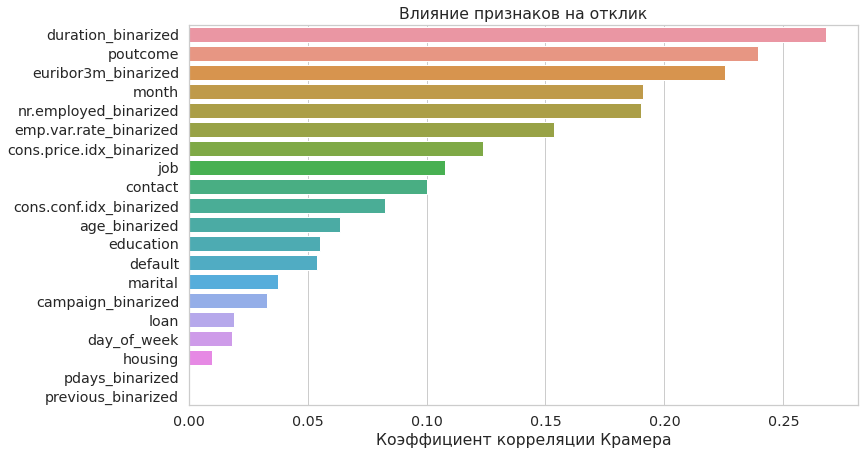

In [ ]:
sns.set(style='whitegrid', font_scale=1.3, palette='Set2')
sorted_order = np.flip(np.argsort(result['Коэффициент Крамера']))

plt.figure(figsize=(12, 7))
sns.barplot(x=result['Коэффициент Крамера'], y=all_features, order=all_features[sorted_order])
plt.xlabel('Коэффициент корреляции Крамера')
plt.title('Влияние признаков на отклик');

Как видим, несколько признаков признаны не влияющими на отклик, на основании МПГ на критерии хи-квадрат.

**2. На основе модели Random Forest**

Сравним с результатом важности признаков по модели Random Forest. Для начала сделаем обработку категориальных признаков

In [ ]:
ord_enc = OrdinalEncoder(dtype='int32')
lab_enc = LabelEncoder()

data[categorical_features] = ord_enc.fit_transform(data[categorical_features])
y = lab_enc.fit_transform(y)

Снова разобъем на трейн и тест с тем же `random_state`.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=1)

Обучаем модель и извлекаем важности признаков

In [ ]:
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

importances = model.feature_importances_

Сортируем признаки в порядке возрастания важности и визуализируем результат

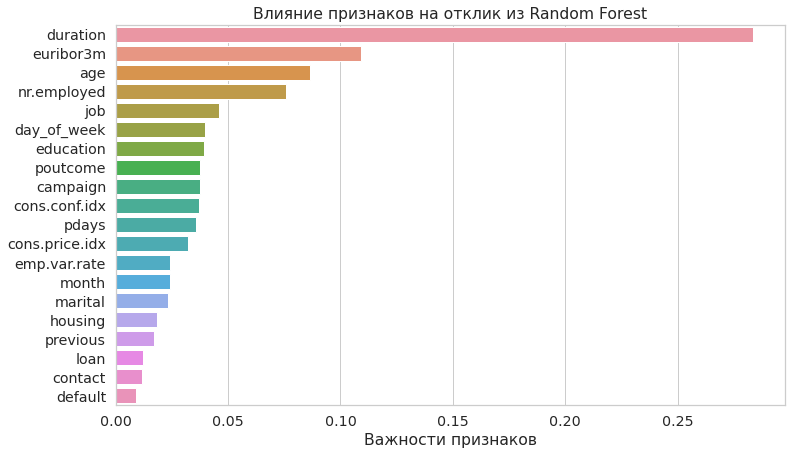

In [ ]:
order = np.flip(np.argsort(importances))

plt.figure(figsize=(12, 7))
sns.barplot(x=importances, y=X_train.columns, order=X_train.columns[order])
plt.xlabel('Важности признаков')
plt.title('Влияние признаков на отклик из Random Forest');

**Вывод:** результаты в первом и во втором случае получились довольно похожими.